In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import binned_statistic # for binning pdays
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_importance

df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
df.info() 

# there are no null entries - this is great

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
df.describe()
# many cols are categorical - run this again later since some col don't make sense

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df = df.rename(columns = {'y':'deposit'}) # change y col to deposit

# Data Wrangling

## Age

In [5]:
unique_ages = df.age.unique()
# sorted(unique_ages)

unique_ages

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88])

Viewing the unique age outputs above.  The age column ranges from 18 to 95 years, which is reasonable.  All of the ages are 2 digit integers so this column is clean.

In [6]:
df.age.mean()

40.93621021432837

The median age is 41 years old.

In [7]:
med_age = df.groupby(['job'])['age'].median()
med_age.sort_values(ascending=False, inplace=True)
med_age # sorting jobs by median age

job
retired          59
unknown          47
housemaid        47
entrepreneur     41
unemployed       40
self-employed    39
blue-collar      39
management       38
admin.           38
technician       37
services         37
student          26
Name: age, dtype: int64

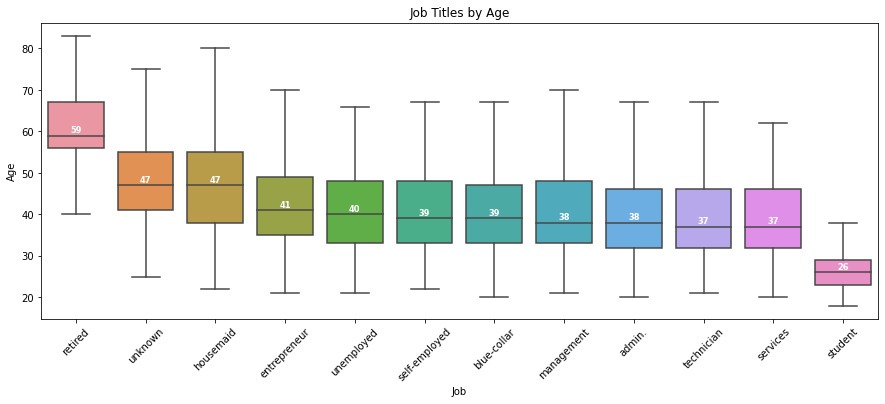

In [8]:
fig = plt.figure(figsize=(15,12))

_ = plt.subplot(2,1,1)
box_plot = sns.boxplot('job','age',data=df,
                       showfliers=False,order=['retired','unknown','housemaid',
                                              'entrepreneur','unemployed','self-employed',
                                              'blue-collar','management','admin.','technician',
                                              'services','student']) #outliers removed
_ = plt.xlabel('Job')
_ = plt.ylabel('Age')
_ = plt.xticks(rotation=45)
_ = plt.title('Job Titles by Age')

vertical_offset = df['age'].median() * 0.02 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,med_age[xtick] + vertical_offset,med_age[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')

## Job

In [9]:
len(df.job.unique())

12

In [10]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

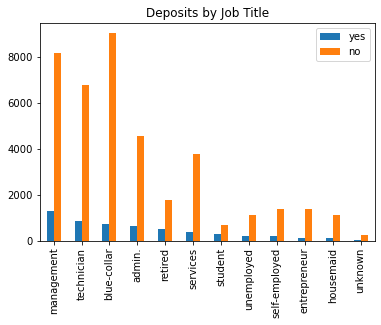

In [11]:
job_df = pd.DataFrame()

job_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
job_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

_ = job_df.plot.bar(title = 'Deposits by Job Title')

In [12]:
job_age = df.groupby(['job'], as_index=False)['age'].median().sort_values('age',ascending=False) # job df grouped by median age

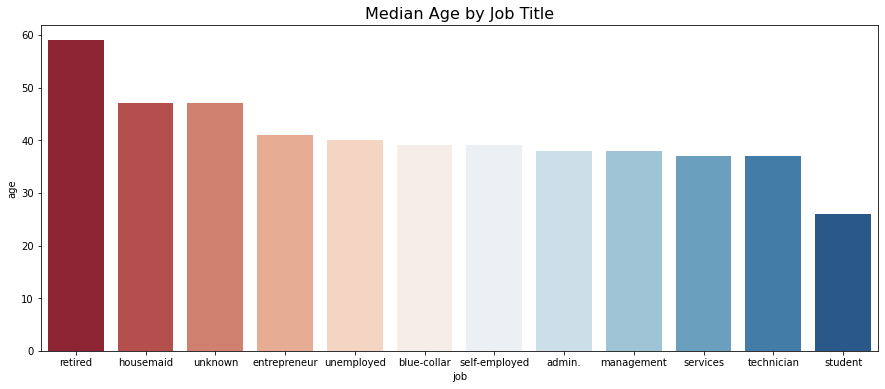

In [13]:
fig = plt.figure(figsize=(15,6))

_ = sns.barplot(x="job", y="age", data=job_age,
            label="Total", palette="RdBu")

_ = plt.title('Median Age by Job Title', fontsize=16)

## Marital

In [14]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

There are 3 unique marital statuses and all are categorical values.

In [15]:
# marital status percentages:

df['marital'].value_counts(normalize=True) * 100

married     60.193316
single      28.289576
divorced    11.517109
Name: marital, dtype: float64

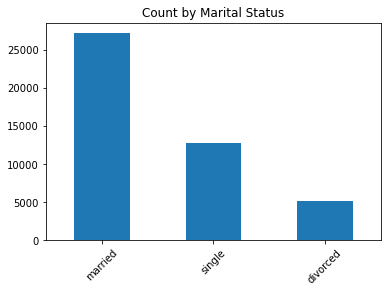

In [16]:
_ = df.marital.value_counts().plot.bar()
_ = plt.xticks(rotation=45)
_ = plt.title('Count by Marital Status')

Married accounts for the majority, then single and divorced last.

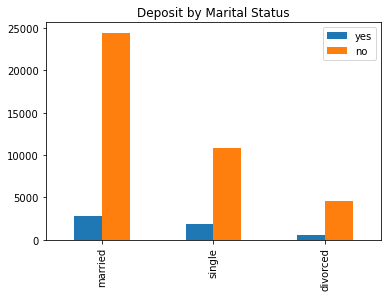

In [17]:
job_df = pd.DataFrame()

job_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
job_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

_ = job_df.plot.bar(title = 'Deposit by Marital Status')

## Education

In [18]:
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

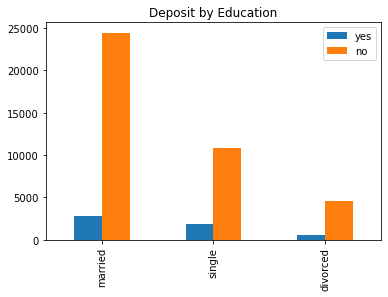

In [19]:
education_df = pd.DataFrame()

education_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
education_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

_ = job_df.plot.bar(title = 'Deposit by Education')

## Default

This column shows whether the person has credit in default

In [20]:
df.default.value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [21]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


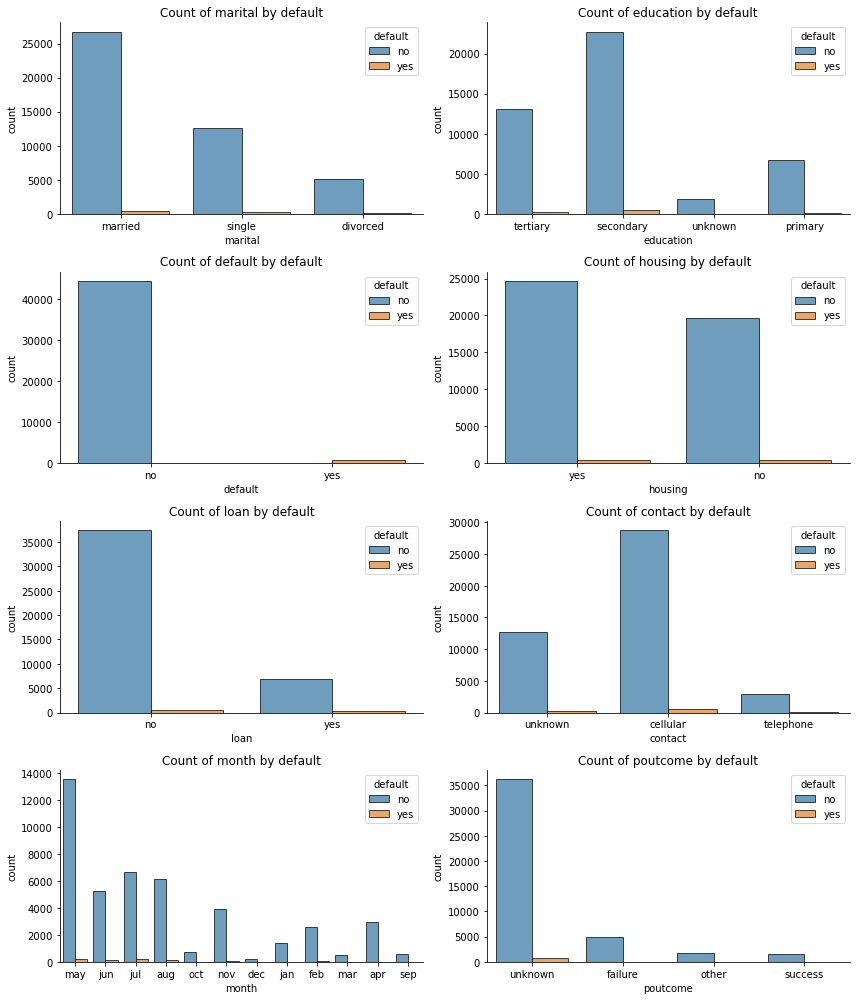

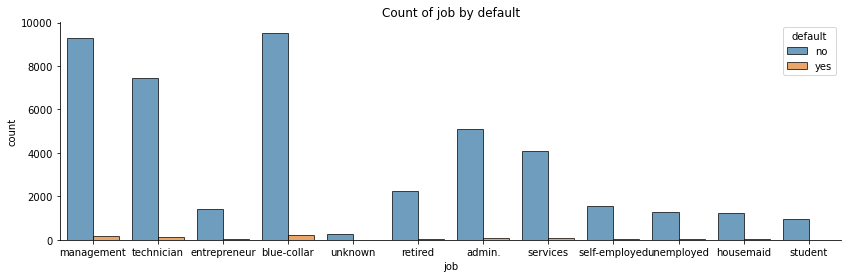

In [22]:
plt.figure(figsize=[12,14])

default_categ = ['marital','education','default','housing','loan','contact','month','poutcome']
n=1

for x in default_categ:
    plt.subplot(4,2,n)
    sns.countplot(x=x, hue='default', edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Count of {} by default".format(x))
    n=n+1
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='default',edgecolor="black", alpha=0.7, data=df)
sns.despine()
plt.title("Count of job by default")
plt.show()

## Balance

In [23]:
len(df.balance.unique())

7168

In [24]:
df.balance.unique()

array([ 2143,    29,     2, ...,  8205, 14204, 16353])

In [25]:
med_balance = df.groupby('job')['balance'].median()
med_balance.sort_values(ascending=False, inplace=True)
med_balance # sorting jobs by median balance

job
retired          787.0
unknown          677.0
management       572.0
unemployed       529.0
self-employed    526.0
student          502.0
technician       421.0
housemaid        406.0
admin.           396.0
blue-collar      388.0
entrepreneur     352.0
services         339.5
Name: balance, dtype: float64

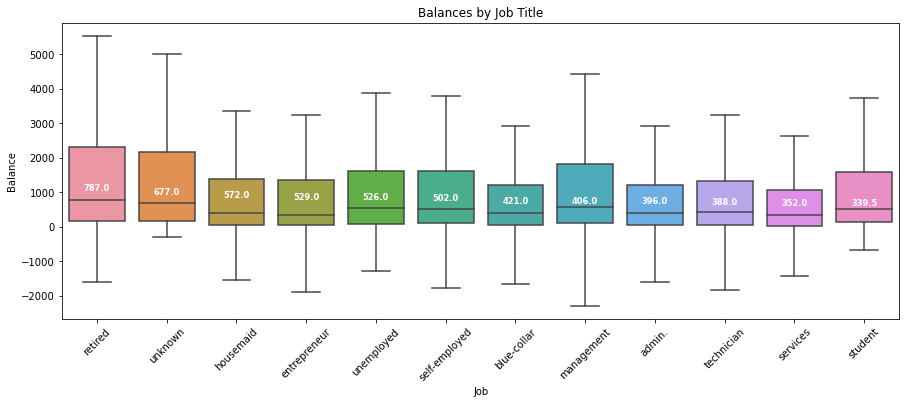

In [26]:
fig = plt.figure(figsize=(15,12))

_ = plt.subplot(2,1,1)
box_plot = sns.boxplot('job','balance',data=df,
                       showfliers=False,order=['retired','unknown','housemaid',
                                              'entrepreneur','unemployed','self-employed',
                                              'blue-collar','management','admin.','technician',
                                              'services','student']) #outliers removed
_ = plt.xlabel('Job')
_ = plt.ylabel('Balance')
_ = plt.xticks(rotation=45)
_ = plt.title('Balances by Job Title')

vertical_offset = df['balance'].median() * 0.6 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,med_balance[xtick] + vertical_offset,med_balance[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')

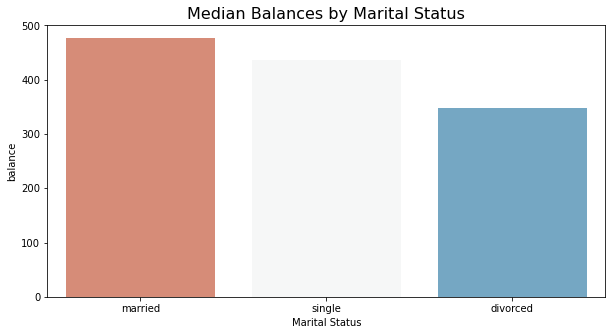

In [27]:
marital_balance = df.groupby(['marital'], as_index=False)['balance'].median().sort_values('balance',ascending=False) # job df grouped by median age

fig = plt.figure(figsize=(10,5))

_ = sns.barplot(x="marital", y="balance", data=marital_balance,
            label="Total", palette="RdBu")

_ = plt.xlabel('Marital Status')
_ = plt.title('Median Balances by Marital Status', fontsize=16)

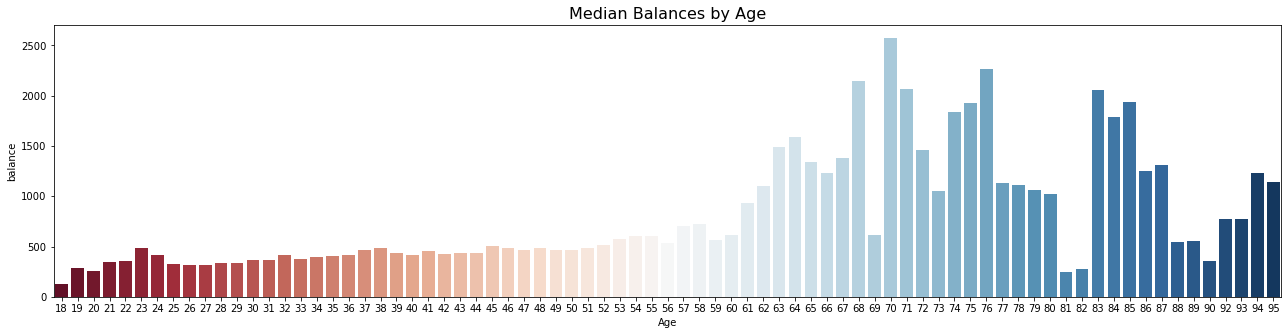

In [28]:
marital_balance = df.groupby(['age'], as_index=False)['balance'].median().sort_values('balance',ascending=False) # job df grouped by median age

fig = plt.figure(figsize=(22,5))

_ = sns.barplot(x="age", y="balance", data=marital_balance,
            label="Total", palette="RdBu")

_ = plt.xlabel('Age')
_ = plt.title('Median Balances by Age', fontsize=16)

## Housing

In [29]:
df.housing.unique()

array(['yes', 'no'], dtype=object)

In [30]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

## Loan

In [31]:
df.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

## Contact

In [32]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

## Day

In [33]:
len(df.day.unique())

31

In [34]:
df.day.unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

## Month

In [35]:
len(df.month.unique())

12

In [36]:
df.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

## Duration

In [37]:
len(df.duration.unique())

1573

In [38]:
df.duration.unique()

array([ 261,  151,   76, ..., 1298, 1246, 1556])

From the UCI website: 

this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

We will drop this column since it is highly correlated to term deposit.

In [39]:
del df['duration'] # removing from df

## Campaign

In [40]:
len(df.campaign.unique())

48

In [41]:
df.campaign.unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])

## Pdays

This is the number of days that passed by after the client was last contacted from a previous campaign.

In [42]:
len(df.pdays.unique())

559

There are too many unique values, so we'll bucket these into categorical values

In [43]:
pdays_df = df.copy() # creating copied df to work with

In [44]:
pdays_df.pdays.min() # min value

-1

In [45]:
pdays_df.pdays.max() # max value

871

In [46]:
import numpy as np
bins = [180, 360, 540, 720, 900]
pdays_df['pdays'] = np.searchsorted(bins, df['pdays'].values)

# pdays are now sorted into bins: 0,1,2,3,4

In [47]:
pdays_df['pdays'].replace({0: 180, 1: 360, 2: 540, 3: 720, 4: 900},inplace=True) # renamed to highest value

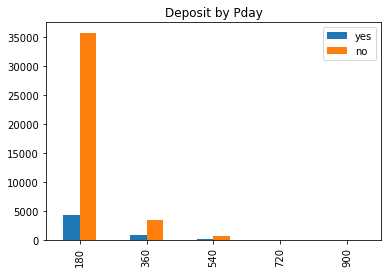

In [48]:
pdays = pd.DataFrame()

pdays['yes'] = pdays_df[pdays_df['deposit'] == 'yes']['pdays'].value_counts()
pdays['no'] = pdays_df[pdays_df['deposit'] == 'no']['pdays'].value_counts()

_ = pdays.plot.bar(title = 'Deposit by Pday')

# the majority of the  pdays are 180 and under

## Previous

In [49]:
len(df.previous.unique())

41

In [50]:
df.previous.unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41])

## Poutcome

In [51]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

## Deposit

In [52]:
df.deposit.unique 

<bound method Series.unique of 0         no
1         no
2         no
3         no
4         no
        ... 
45206    yes
45207    yes
45208    yes
45209     no
45210     no
Name: deposit, Length: 45211, dtype: object>

In [53]:
df['deposit'].value_counts()

no     39922
yes     5289
Name: deposit, dtype: int64

In [54]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


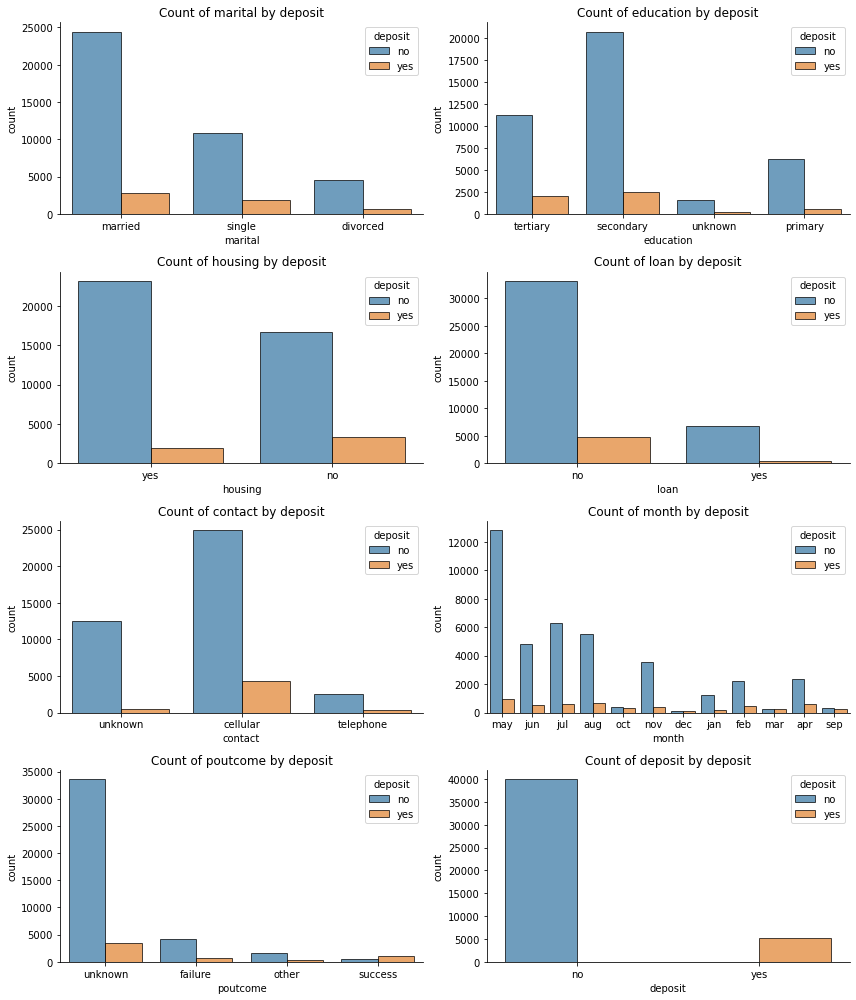

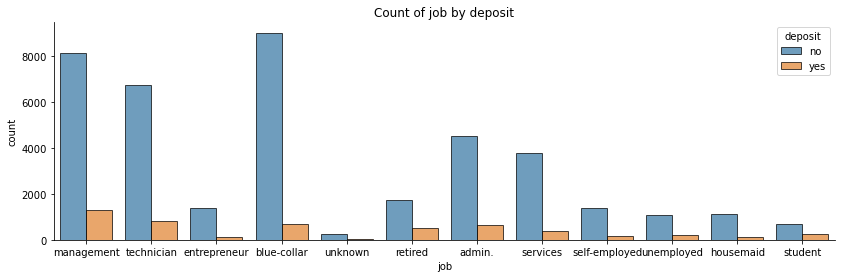

In [55]:
plt.figure(figsize=[12,14])

deposit_categ = ['marital','education','housing','loan','contact','month','poutcome','deposit']
                 
n=1 

for x in deposit_categ:
    plt.subplot(4,2,n)
    sns.countplot(x=x, hue='deposit', edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Count of {} by deposit".format(x))
    n=n+1
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=df)
sns.despine()
plt.title("Count of job by deposit")
plt.show()

## Categorical - Continuous Data

In [56]:
categ_cont_df = df[['default','housing','loan','deposit']]

In [57]:
categ_cont_df['default'] = categ_cont_df['default'].map({'yes': '1', 'no': '0'})
categ_cont_df['housing'] = categ_cont_df['housing'].map({'yes': '1', 'no': '0'})
categ_cont_df['loan'] = categ_cont_df['loan'].map({'yes': '1', 'no': '0'})
categ_cont_df['deposit'] = categ_cont_df['deposit'].map({'yes': '1', 'no': '0'})

<ipython-input-57-7e6cf1f554b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['default'] = categ_cont_df['default'].map({'yes': '1', 'no': '0'})
<ipython-input-57-7e6cf1f554b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['housing'] = categ_cont_df['housing'].map({'yes': '1', 'no': '0'})
<ipython-input-57-7e6cf1f554b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [58]:
# converting to integer

categ_cont_df['default'] = categ_cont_df['default'].astype(int)
categ_cont_df['loan'] = categ_cont_df['loan'].astype(int)
categ_cont_df['housing'] = categ_cont_df['housing'].astype(int)
categ_cont_df['deposit'] = categ_cont_df['deposit'].astype(int)

<ipython-input-58-61f9d72f660e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['default'] = categ_cont_df['default'].astype(int)
<ipython-input-58-61f9d72f660e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['loan'] = categ_cont_df['loan'].astype(int)
<ipython-input-58-61f9d72f660e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [59]:
# point-biseral

for x, y in categ_cont_df.iteritems():
    pointbi = stats.pointbiserialr(categ_cont_df.default,y)   
    print(pointbi, x)

PointbiserialrResult(correlation=0.9999999999999963, pvalue=0.0) default
PointbiserialrResult(correlation=-0.006025218356252599, pvalue=0.20015465917581932) housing
PointbiserialrResult(correlation=0.07723424107915192, pvalue=8.909521427986304e-61) loan
PointbiserialrResult(correlation=-0.022418965890751284, pvalue=1.8663265262329448e-06) deposit


In [60]:
categ_cont_corr = categ_cont_df.corr()
categ_cont_corr

,default,housing,loan,deposit
default,1.000000,-0.006025,0.077234,-0.022419
housing,-0.006025,1.000000,0.041323,-0.139173
loan,0.077234,0.041323,1.000000,-0.068185
deposit,-0.022419,-0.139173,-0.068185,1.000000


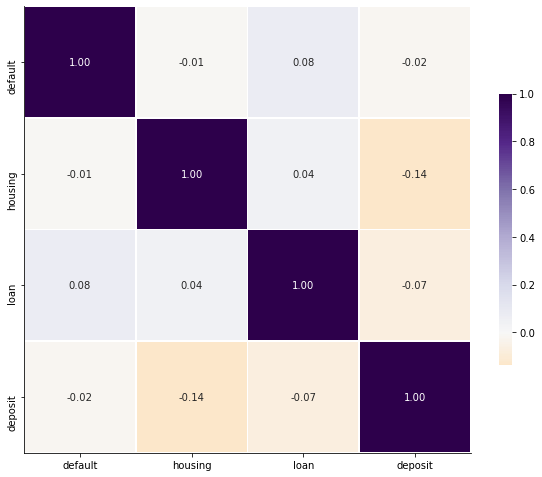

In [61]:
ax = sns.heatmap(categ_cont_corr,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
ax.figure.set_size_inches(10,10)
 
bottom, top = ax.get_ylim()

plt.show()

In [62]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


## Continuous Data

In [63]:
df['deposit'] = LabelEncoder().fit_transform(df['deposit']) # transforming categorical values to integers

In [64]:
continuous_df = pd.DataFrame(df, columns=['deposit','age','balance','day','campaign','pdays','previous'])
continuous_df_corr = continuous_df.corr()

In [65]:
continuous_df_corr # getting correlations

,deposit,age,balance,day,campaign,pdays,previous
deposit,1.000000,0.025155,0.052838,-0.028348,-0.073172,0.103621,0.093236
age,0.025155,1.000000,0.097783,-0.009120,0.004760,-0.023758,0.001288
balance,0.052838,0.097783,1.000000,0.004503,-0.014578,0.003435,0.016674
day,-0.028348,-0.009120,0.004503,1.000000,0.162490,-0.093044,-0.051710
campaign,-0.073172,0.004760,-0.014578,0.162490,1.000000,-0.088628,-0.032855
pdays,0.103621,-0.023758,0.003435,-0.093044,-0.088628,1.000000,0.454820
previous,0.093236,0.001288,0.016674,-0.051710,-0.032855,0.454820,1.000000


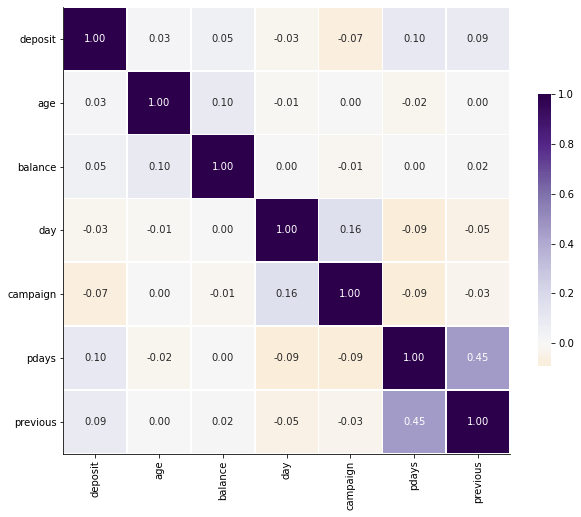

In [66]:
ax = sns.heatmap(continuous_df_corr,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
ax.figure.set_size_inches(10,10)

plt.show()

In [67]:
df_clean = df.copy()

In [68]:
# Y/N data transformation

df_clean['default'] = df_clean['default'].map({'yes': '1', 'no': '0'})
df_clean['housing'] = df_clean['housing'].map({'yes': '1', 'no': '0'})
df_clean['loan'] = df_clean['loan'].map({'yes': '1', 'no': '0'})

In [69]:
# converting to integer, not object

df_clean['default'] = df_clean['default'].astype(int)
df_clean['housing'] = df_clean['housing'].astype(int)
df_clean['loan'] = df_clean['loan'].astype(int)

In [70]:
 #convert categorical columns to dummies
cat_columns = ['job', 'marital', 'education', 'contact', 'poutcome']

In [71]:
# create dummy variables for categorical cols

for col in  cat_columns:
    df_clean = pd.concat([df_clean.drop(col, axis=1), pd.get_dummies(df_clean[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)

In [72]:
# drop irrelevant cols

df_clean.drop([
        'campaign',
        'pdays',
        'previous',
        'month'], axis=1,inplace=True)

In [73]:
df_clean.head()

,age,default,balance,housing,loan,day,deposit,job_blue-collar,job_entrepreneur,job_housemaid,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,44,0,29,1,0,5,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1
2,33,0,2,1,1,5,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,0,1,0,0,...,1,0,0,0,1,0,1,0,0,1
4,33,0,1,0,0,5,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [74]:
X = df_clean.drop(columns = 'deposit')
y = df_clean[['deposit']]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [76]:
#train XGBoost

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.903: test: 0.895


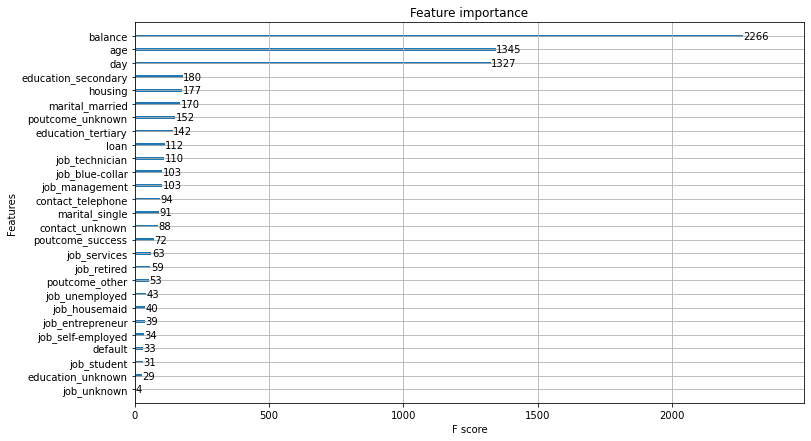

In [92]:
fig, ax = plt.subplots(figsize=(12, 7))

plot_importance(xgb, ax=ax)
plt.show()